In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
import torch.nn.functional as F
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import seaborn as sns
import random
import os

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALPHA = 0.5  
BETA = 0.1   
temperature = 4
css_alpha = 0.05  
max_css_batches = 10  
num_bins = 10    

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


dataset = get_dataset(dataset="waterbirds", download=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = dataset.get_subset("train", transform=transform)
val_data = dataset.get_subset("val", transform=transform)
test_data = dataset.get_subset("test", transform=transform)

train_loader = get_train_loader("standard", train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

metadata_array = test_data.metadata_array
bird_type_idx = dataset.metadata_fields.index('y')
background_idx = dataset.metadata_fields.index('background')

bird_type = metadata_array[:, bird_type_idx]
background = metadata_array[:, background_idx]

id_mask = ((bird_type == 0) & (background == 0)) | ((bird_type == 1) & (background == 1))
id_indices = torch.where(id_mask)[0]
id_data = Subset(test_data, id_indices)
id_loader = DataLoader(id_data, batch_size=BATCH_SIZE, shuffle=False)

ood_mask = ((bird_type == 0) & (background == 1)) | ((bird_type == 1) & (background == 0))
ood_indices = torch.where(ood_mask)[0]
ood_data = Subset(test_data, ood_indices)
ood_loader = DataLoader(ood_data, batch_size=BATCH_SIZE, shuffle=False)

teacher_model = models.resnet50(pretrained=True)
num_ftrs_teacher = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs_teacher, 2)  
teacher_model = teacher_model.to(DEVICE)

student_model = models.resnet18(pretrained=True)
num_ftrs_student = student_model.fc.in_features
student_model.fc = nn.Linear(num_ftrs_student, 2)  
student_model = student_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()


def get_feature_embeddings(model, x, layer_name='layer4'):
    features = []

    def hook(module, input, output):
        features.append(output)

    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook)
            break

    model(x)

    if not features:
        print(f"Warning: Hook did not capture any features from layer '{layer_name}'. Check layer name.")
        if layer_name == 'layer4':
            return torch.zeros(x.size(0), 512).to(x.device)  
        elif layer_name == 'layer4_resnet50':
            return torch.zeros(x.size(0), 2048).to(x.device)  
        else:
            return torch.zeros(x.size(0), 512).to(x.device)  
    else:
        pass
    
    return features[0].view(x.size(0), -1)  

def extract_color_features(x):
    return x.view(x.size(0), x.size(1), -1).mean(dim=2).transpose(0,1).transpose(0,1)  # (N, 3)

def compute_cross_covariance(F, C):
    N = F.size(0)
    F_centered = F - F.mean(dim=0, keepdim=True)
    C_centered = C - C.mean(dim=0, keepdim=True)
    covariance = (F_centered.T @ C_centered) / (N - 1)
    return covariance

def feature_decorrelation_loss(F, C):
    covariance = compute_cross_covariance(F, C)
    loss = torch.norm(covariance, p='fro')**2
    return loss

def compute_bias_mitigation_index(model, data_loader, device, num_bins=10):
    model.eval()
    all_preds = []
    all_color_features = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Computing BMI", leave=False):
            inputs, labels, _ = batch
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

            color_feats = extract_color_features(inputs)
            all_color_features.extend(color_feats.cpu().numpy())

    all_preds = np.array(all_preds)
    all_color_features = np.array(all_color_features) 

    est = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
    color_discrete = est.fit_transform(all_color_features).astype(int)

    color_discrete = color_discrete[:,0] * num_bins**2 + color_discrete[:,1] * num_bins + color_discrete[:,2]

    bmi = mutual_info_score(all_preds, color_discrete)

    return bmi

def compute_feature_independence_score(model, data_loader, device):
    model.eval()
    all_features = []
    all_color_features = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Computing FIS", leave=False):
            inputs, _, _ = batch
            inputs = inputs.to(device)

            features = get_feature_embeddings(model, inputs, layer_name='layer4')  
            all_features.append(features.cpu().numpy())

            color_feats = extract_color_features(inputs)
            all_color_features.append(color_feats.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)  
    all_color_features = np.concatenate(all_color_features, axis=0)  

    print(f"All Features Shape: {all_features.shape}")
    print(f"All Color Features Shape: {all_color_features.shape}")

    try:
        combined = np.hstack((all_features, all_color_features))  
        correlation_matrix = np.corrcoef(combined, rowvar=False)  
        feature_color_corr = correlation_matrix[:all_features.shape[1], all_features.shape[1]:]  
    except ValueError as e:
        print(f"Error computing correlation matrix: {e}")
        return 0.0

    if feature_color_corr.size == 0:
        print("Error: Correlation matrix is empty.")
        return 0.0

    feature_color_corr = np.nan_to_num(feature_color_corr)

    rho_max = np.max(np.abs(feature_color_corr))
    print(f"Maximum Absolute Correlation (rho_max): {rho_max}")

    fis = 1 - rho_max
    print(f"Computed FIS: {fis}")

    return fis

def compute_color_sensitivity_score(model, data_loader, epsilon=0.1):
    model.eval()
    total_score = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Computing CSS", leave=False):
            if len(batch) == 3:
                images, labels, _ = batch 
            elif len(batch) == 2:
                images, labels = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            original_preds = F.softmax(model(images), dim=1)

            for channel in range(3):  
                perturbed_images = images.clone()
                perturbed_images[:, channel, :, :] += epsilon
                perturbed_images = torch.clamp(perturbed_images, 0, 1)  
                
                perturbed_preds = F.softmax(model(perturbed_images), dim=1)

                sensitivity = torch.mean(torch.sum(torch.abs(original_preds - perturbed_preds), dim=1))
                total_score += sensitivity.item() * images.size(0)

            total_samples += images.size(0)

    avg_css = total_score / (total_samples * 3)  
    return avg_css

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            inputs, labels, _ = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total if total != 0 else 0.0
    print(f"Evaluation Accuracy: {acc:.4f}")
    return acc


def train_teacher(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    model.train()
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in tqdm(train_loader, desc=f"Teacher Training Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels, _ = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total if total != 0 else 0.0
        epoch_acc = correct / total if total != 0 else 0.0

        val_acc = evaluate(model, val_loader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            print(f"New best teacher model saved with Val Acc: {val_acc:.4f}")

        print(f'Teacher Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}')

    if best_model_state:
        torch.save(best_model_state, 'best_teacher_model_FD.pth')
        print("Best teacher model saved to 'best_teacher_model_FD.pth'")

    print('Teacher training complete')
    return model

def train_student(teacher, student, train_loader, val_loader, optimizer, criterion, alpha, beta, num_epochs, device):
    teacher.eval()  # Teacher is fixed
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Student Training Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels, _ = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            student_outputs = student(inputs)

            KD_loss = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1),
                               F.softmax(teacher_outputs / temperature, dim=1),
                               reduction='batchmean') * (temperature ** 2)

            student_features = get_feature_embeddings(student, inputs, layer_name='layer4')
            color_features = extract_color_features(inputs).to(device)
            decorrelation_loss = feature_decorrelation_loss(student_features, color_features)

            loss = alpha * KD_loss + criterion(student_outputs, labels) + beta * decorrelation_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(student_outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total if total != 0 else 0.0
        epoch_acc = correct / total if total != 0 else 0.0

        val_acc = evaluate(student, val_loader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = student.state_dict()
            print(f"New best student model saved with Val Acc: {val_acc:.4f}")

        print(f'Student Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}')

    if best_model_state:
        torch.save(best_model_state, 'best_student_model_FD.pth')
        print("Best student model saved to 'best_student_model_FD.pth'")

    print('Student training complete')
    return student


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, data_loader, device, layer_name='layer4', num_images=5):
    
    model.eval()
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    if target_layer is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=None)
    
    images_so_far = 0
    plt.figure(figsize=(15, num_images * 5))
    
    for batch in data_loader:
        inputs, labels, _ = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        grayscale_cams = cam(inputs)  
    
        for i in range(inputs.size(0)):
            if images_so_far >= num_images:
                break
    
            img = inputs[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
    
            cam_image = show_cam_on_image(img, grayscale_cams[i], use_rgb=True)
    
            plt.subplot(num_images, 2, images_so_far * 2 + 1)
            plt.imshow(img)
            plt.title(f"Original Image - Label: {labels[i].item()}")
            plt.axis("off")
    
            plt.subplot(num_images, 2, images_so_far * 2 + 2)
            plt.imshow(cam_image)
            plt.title("Grad-CAM")
            plt.axis("off")
    
            images_so_far += 1
    
        if images_so_far >= num_images:
            break
    
    plt.tight_layout()
    plt.show()



print(f"Train Loader Dataset Size: {len(train_loader.dataset)}")
print(f"Validation Loader Dataset Size: {len(val_loader.dataset)}")
print(f"Test Loader Dataset Size: {len(test_loader.dataset)}")
print(f"ID Loader Dataset Size: {len(id_loader.dataset)}")
print(f"OOD Loader Dataset Size: {len(ood_loader.dataset)}")

# print("\nTraining Teacher Model...")
# teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=LEARNING_RATE)
# teacher_model = train_teacher(
#     teacher_model,
#     train_loader,
#     val_loader,
#     teacher_optimizer,
#     criterion,
#     num_epochs=NUM_EPOCHS,
#     device=DEVICE
# )

# print("\nTraining Student Model...")
# student_optimizer = optim.Adam(student_model.parameters(), lr=LEARNING_RATE)

# student_model = train_student(
#     teacher_model,
#     student_model,
#     train_loader,
#     val_loader,
#     student_optimizer,
#     criterion,
#     alpha=ALPHA,
#     beta=BETA,
#     num_epochs=NUM_EPOCHS,
#     device=DEVICE
# )

teacher_model.load_state_dict(torch.load('best_teacher_model.pth'))

student_model.load_state_dict(torch.load('best_student_model.pth'))

print("\nEvaluating Student Model...")
id_accuracy = evaluate(student_model, id_loader, DEVICE)
ood_accuracy = evaluate(student_model, ood_loader, DEVICE)
overall_accuracy = evaluate(student_model, test_loader, DEVICE)

print(f'\nID Accuracy: {id_accuracy:.4f}')
print(f'OOD Accuracy: {ood_accuracy:.4f}')
print(f'Overall Test Accuracy: {overall_accuracy:.4f}')

print("\nComputing Metrics...")
B_MI = compute_bias_mitigation_index(student_model, test_loader, DEVICE, num_bins=num_bins)
FIS = compute_feature_independence_score(student_model, test_loader, DEVICE)
CSS = compute_color_sensitivity_score(student_model, test_loader, epsilon=css_alpha)

print(f'\nBias Mitigation Index (BMI): {B_MI:.4f}')
print(f'Feature Independence Score (FIS): {FIS:.4f}')
print(f'Color Sensitivity Score (CSS): {CSS:.4f}')



c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most 

Train Loader Dataset Size: 4795
Validation Loader Dataset Size: 1199
Test Loader Dataset Size: 5794
ID Loader Dataset Size: 2897
OOD Loader Dataset Size: 2897

Training Teacher Model...


C:\Users\abdul\AppData\Local\Temp\ipykernel_13800\3597191232.py:612: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load('best_student_mod


Evaluating Student Model...


Evaluation Accuracy: 0.9617


Evaluation Accuracy: 0.4833


Evaluation Accuracy: 0.7225

ID Accuracy: 0.9617
OOD Accuracy: 0.4833
Overall Test Accuracy: 0.7225

Computing Metrics...


All Features Shape: (5794, 25088)
All Color Features Shape: (5794, 3)
Maximum Absolute Correlation (rho_max): 0.6528665041493131
Computed FIS: 0.34713349585068687



Bias Mitigation Index (BMI): 0.1594
Feature Independence Score (FIS): 0.3471
Color Sensitivity Score (CSS): 0.0558


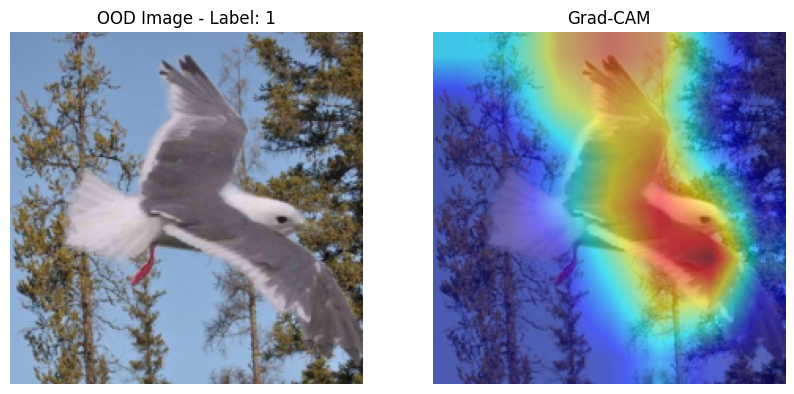

In [50]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

def visualize_random_ood_gradcam(model, ood_loader, device, layer_name='layer4'):
    
    model.eval()

    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    if target_layer is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=None)

    batch = random.choice(list(ood_loader))
    inputs, labels, _ = batch
    idx = random.randint(0, inputs.size(0) - 1)

    inputs = inputs.to(device)
    input_img = inputs[idx].unsqueeze(0)  
    label = labels[idx].item()

    grayscale_cam = cam(input_tensor=input_img)[0]

    img = input_img[0].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"OOD Image - Label: {label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

visualize_random_ood_gradcam(student_model, ood_loader, DEVICE, layer_name='layer4')
